In [1]:
import joblib
import sys
import pathlib
import yaml
import subprocess

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

2025-05-05 15:31:45.870079: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-05 15:31:45.879339: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746480705.888468   32305 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746480705.891396   32305 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746480705.899369   32305 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Metadata Column Definition

In [2]:
CELL_TYPE_COL = 'encode_celltype'
SAMPLE_ID_COL = 'sample_id'
STIM_COL = 'stim'
TECH_COL = 'samp_type'
DATASPLIT_COL = 'isTraining'

GENE_ID_COL = 'gene_ids'

## Obtain repository root directory for access to preprocessed data, config file and local package

In [3]:
# Get the root directory of the analysis repository
REPO_ROOT = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()
REPO_ROOT = pathlib.Path(REPO_ROOT)

CONFIG_FILE = REPO_ROOT / 'config.yml'
assert CONFIG_FILE.exists(), f"Config file not found at {CONFIG_FILE}"

with open(CONFIG_FILE, 'r') as file:
    config_dict = yaml.safe_load(file)

### Import packages

In [4]:
buddi_fork_path = config_dict['software_path']['buddi_v2']
buddi_fork_path = pathlib.Path(buddi_fork_path)
assert buddi_fork_path.exists(), f"buddi fork not found at {buddi_fork_path}"

sys.path.append(str(REPO_ROOT))
sys.path.append(str(buddi_fork_path))
# this is quite ugly, once activate modifications are done this will be changed
# to a proper installation + import
from analysis_utils.buddi4data import BuDDI4Data
from buddi_v2.dataset.buddi4_dataset import get_supervised_dataset, get_unsupervised_dataset
from buddi_v2.models.buddi4 import fit_buddi4
from buddi_v2.models.components.losses import unsupervised_dummy_loss_fn
from buddi_v2.models.buddi4_class import BuDDI4
from buddi_v2.plotting.plot_latent_space import plot_latent_spaces_buddi4
from buddi_v2.plotting.plot_data import plot_data

I0000 00:00:1746480706.865693   32305 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6423 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


## Define paths to Input Files/Output

### Input from pre-processing

In [5]:
PREPROCESSING_OUTPUT_PATH = REPO_ROOT / 'processed_data' 
train_data_file = PREPROCESSING_OUTPUT_PATH / 'buddi4_train_data.pkl'
assert train_data_file.exists(), f"Train data file not found at {train_data_file}"

### Trained model save path

In [6]:
TRAINED_MODELS_PATH = REPO_ROOT / 'trained'
model_folders = sorted(TRAINED_MODELS_PATH.glob('buddi4_*'))
assert len(model_folders) > 0, f"No trained models found in {TRAINED_MODELS_PATH}"

In [7]:
model_folders

[PosixPath('/home/weishanli/CU/DavidsonLab/BuddiHGSC/HGSC_buddi_subtype_analysis/trained/buddi4_alpha=10.0_beta=10.0'),
 PosixPath('/home/weishanli/CU/DavidsonLab/BuddiHGSC/HGSC_buddi_subtype_analysis/trained/buddi4_alpha=100.0_beta=10.0_beta_slack=1000.0'),
 PosixPath('/home/weishanli/CU/DavidsonLab/BuddiHGSC/HGSC_buddi_subtype_analysis/trained/buddi4_alpha=100.0_beta=100.0'),
 PosixPath('/home/weishanli/CU/DavidsonLab/BuddiHGSC/HGSC_buddi_subtype_analysis/trained/buddi4_alpha=100.0_beta=100.0_beta_slack=0.1')]

## Load Data

In [8]:
train_data = joblib.load(train_data_file)
print(train_data)
print('\n')

n_x = len(train_data.gene_names)
n_y = len(train_data.cell_type_names)
n_labels = train_data.encode_meta[SAMPLE_ID_COL].shape[1]
n_stims = train_data.encode_meta[STIM_COL].shape[1]
n_samp_types = train_data.encode_meta[TECH_COL].shape[1]
print(f"Number of genes: {n_x}")
print(f"Number of cell types: {n_y}")
print(f"Number of unique labels: {n_labels}")
print(f"Number of unique stimulations: {n_stims}")
print(f"Number of unique sample types: {n_samp_types}")

BuDDIData(unkp_samples=588, kp_samples=8400, genes=7000, cell_types=11)


Number of genes: 7000
Number of cell types: 11
Number of unique labels: 593
Number of unique stimulations: 2
Number of unique sample types: 2


## Load Trained model

In [9]:
obj = BuDDI4.load(
    '/home/weishanli/CU/DavidsonLab/BuddiHGSC/HGSC_buddi_subtype_analysis/trained/buddi4_alpha=100.0_beta=100.0_beta_slack=0.1'
)

In [10]:
print(obj.encoders)
print(obj.decoder)
print(obj.prop_estimator)

{'label': <Functional name=encoder_label, built=True>, 'stim': <Functional name=encoder_stim, built=True>, 'samp_type': <Functional name=encoder_samp_type, built=True>, 'slack': <Functional name=encoder_slack, built=True>}
<Functional name=shared_X_decoder, built=True>
<Functional name=prop_estimator, built=True>


In [11]:
from analysis_utils.validation.perturb_cell_type import perturb_cell_type
from analysis_utils.validation.resample import reconstruct
from analysis_utils.validation.plot_perturb import plot_perturb_reduction, plot_corr_matrix_with_metadata

## Perturb Cell Type Proportions

In [12]:
x_perturb, meta_perturb = perturb_cell_type(
    obj=obj,
    data=train_data,
    cell_type_col='cell_type',
    idx=None,
    n_subsamples=500,
    seed=42,
)

Perturb CT: 100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


In [13]:
x_perturb.shape

(55000, 7000)

In [14]:
meta_perturb.head()

,sample_id,stim,samp_type,isTraining,cell_prop_type,cell_type,reconstruction_type,perturb_type,source,target
0,Samp-T76,white,sc_ref,Train,single_celltype,Adipocytes,perturbed,cell_type,Adipocytes,B-cells
1,Samp-T90,white,sc_ref,Train,single_celltype,Adipocytes,perturbed,cell_type,Adipocytes,B-cells
2,Samp-T76,white,sc_ref,Train,single_celltype,Adipocytes,perturbed,cell_type,Adipocytes,B-cells
3,Samp-T89,white,sc_ref,Train,single_celltype,Adipocytes,perturbed,cell_type,Adipocytes,B-cells
4,Samp-T77,white,sc_ref,Train,single_celltype,Adipocytes,perturbed,cell_type,Adipocytes,B-cells


In [15]:
x_reconstruct, meta_reconstruct = reconstruct(
    obj=obj,
    data=train_data,
    idx=None,
    n_resamples=1,
    seed=42,
)

In [16]:
x_reconstruct.shape

(8400, 7000)

In [17]:
meta_reconstruct.head()

,sample_id,stim,samp_type,isTraining,cell_prop_type,cell_type,reconstruction_type,perturb_type,source,target
0,Samp-T77,white,sc_ref,Train,random,random,reconstruction,unperturbed,None,None
1,Samp-T77,white,sc_ref,Train,random,random,reconstruction,unperturbed,None,None
2,Samp-T77,white,sc_ref,Train,random,random,reconstruction,unperturbed,None,None
3,Samp-T76,white,sc_ref,Train,single_celltype,Fibroblasts,reconstruction,unperturbed,None,None
4,Samp-T77,white,sc_ref,Train,single_celltype,Macrophages,reconstruction,unperturbed,None,None


## Visualize

/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


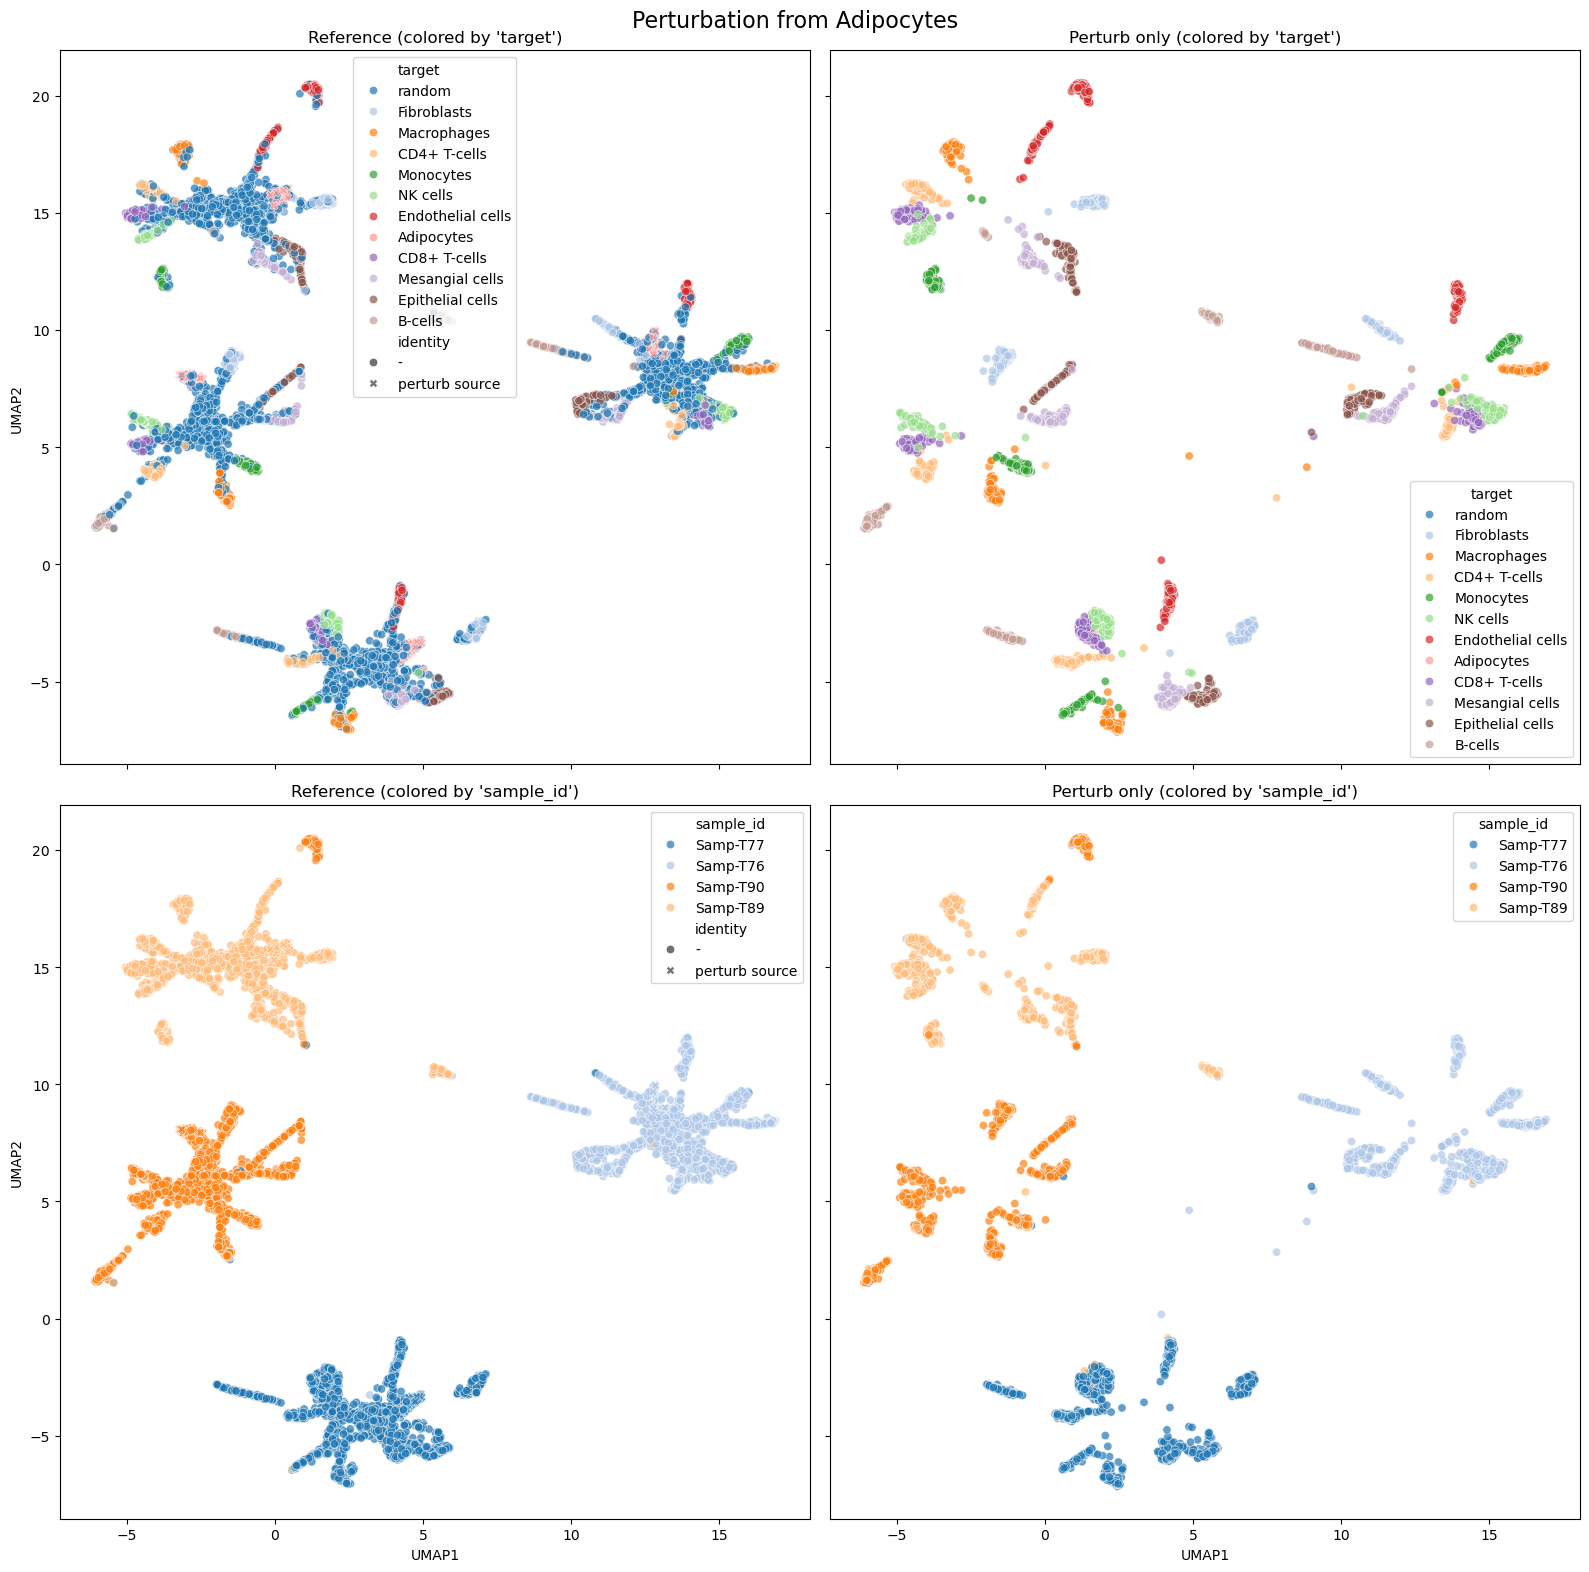

In [18]:
plot_perturb_reduction(
    x_basis=x_reconstruct,
    meta_basis=meta_reconstruct,
    x_perturb=x_perturb,
    meta_perturb=meta_perturb,
    down_sample_basis_n=None,
    filter_source='Adipocytes',
    filter_target=None,
    color_by=['sample_id'],
    reduction_method='UMAP',
    reduction_kwargs={'random_state': 0},
    panel_width=8,
    title='Perturbation from Adipocytes',
    show_plot=True,
    save_path=None
)

## Also Examine single-cell reference reconstruction

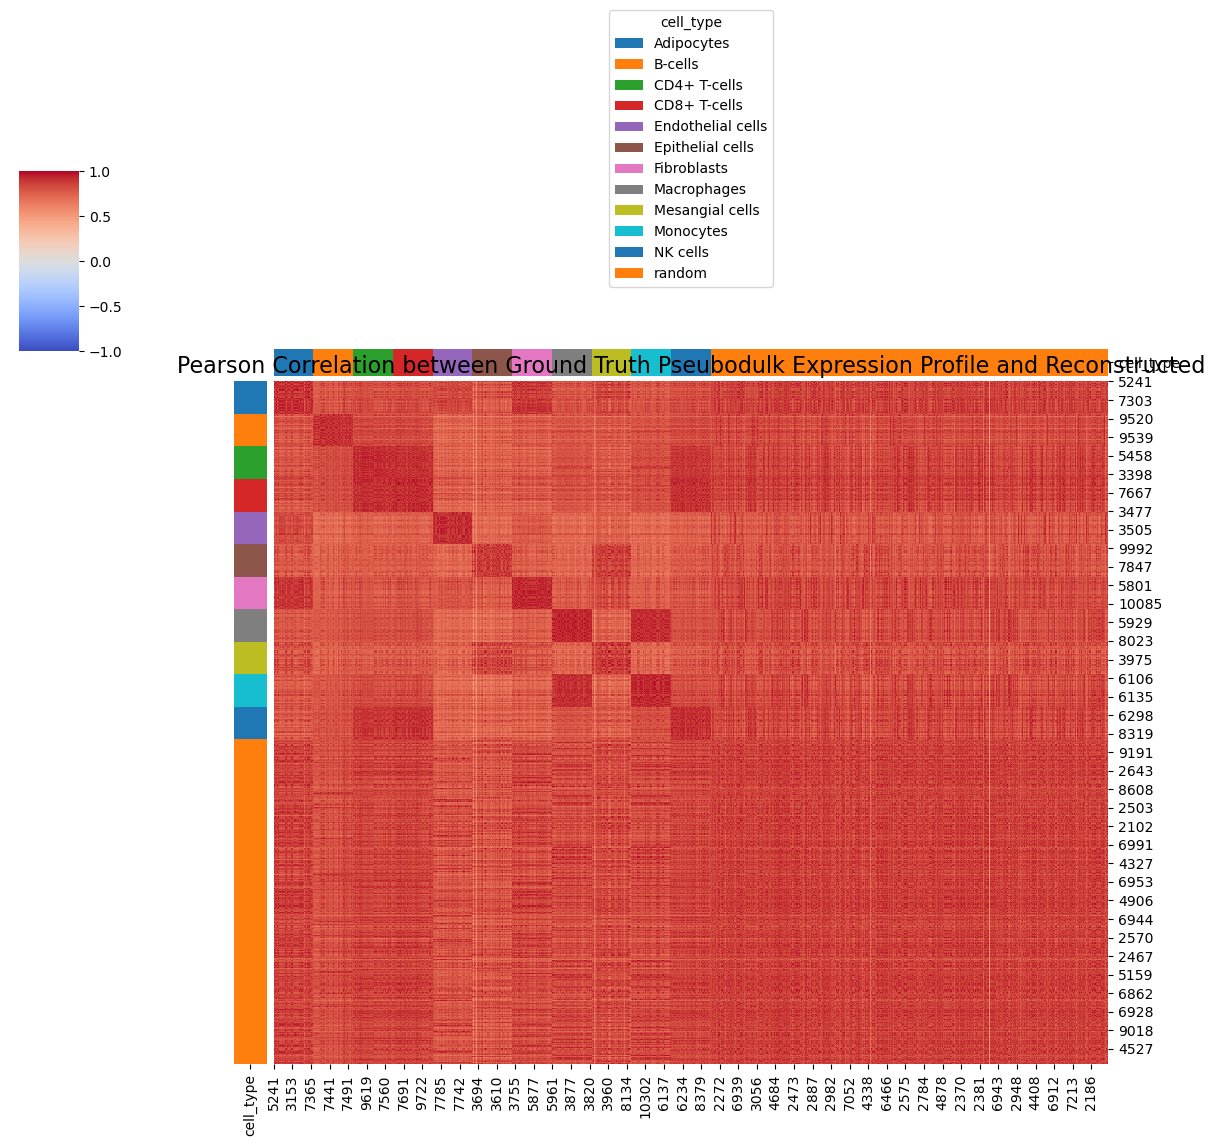

In [19]:
plot_corr_matrix_with_metadata(
    train_data.get(condition='kp', key='X'),
    x_reconstruct,
    train_data.get(condition='kp', key='meta'),
    meta_col='cell_type',
    figsize=(12, 10),
    title='Pearson Correlation between Ground Truth Pseubodulk Expression Profile and Reconstructed',
    heatmap_cmap='coolwarm',
    cluster=False
)